In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

Firstly, let's define a function to perform [AdaM](https://arxiv.org/abs/1412.6980) updates...

In [3]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

## 1.  [A Generative Deep Recurrent Model for Exchangeable Data](https://arxiv.org/abs/1802.07535)
#### by [Iryna Korshunova](http://irakorshunova.github.io/about.html), [Jonas Degrave](https://scholar.google.nl/citations?user=M3bkh8MAAAAJ&hl=en), [Ferenc Huszar](http://www.inference.vc/about/), [Yarin Gal](http://www.cs.ox.ac.uk/people/yarin.gal/website/index.html), [Arthur Gretton ](http://www.gatsby.ucl.ac.uk/~gretton/), and [Joni Dambre](http://reslab.elis.ugent.be/node/224)

A sequence of random variables is called *exchangeable* if their joint distribution is invariant to permutation: $$ p(\mathbf{x}_{1},\ldots,\mathbf{x}_{N}) =  p(\mathbf{x}_{\pi(1)},\ldots,\mathbf{x}_{\pi(N)})$$ where $(\pi(1),\ldots,\pi(N))$ denotes a permutation of $1,\ldots, N$.  Clearly, the usual i.i.d. assumption $p(\mathbf{x}_{1},\ldots,\mathbf{x}_{N}) = \prod_{i=1}^{N} p(\mathbf{x}_{i})$ due to the commutativity of multiplication.  However, the i.i.d. assumption is stronger than exchangeability, and data can be correlated while still being exchangeable.  De Finetti's representation theorem gives a general condition for exchangeability, deeming data exchangeable if we can model it as conditionally independent given some latent variable $\boldsymbol{\theta}$: $$ p(\mathbf{x}_{\pi(1)},\ldots,\mathbf{x}_{\pi(N)})=  \int_{\boldsymbol{\theta}} p(\boldsymbol{\theta}) \prod_{i=1}^{N} p(\mathbf{x}_{i} | \boldsymbol{\theta}) \ d \boldsymbol{\theta}.$$  De Finetti's theorem can be seen as a fundamental justification for Bayesian inference: if we assume data are exchangeable, then some prior must have generated it.  Alternatively, we can write the representation in terms of a predictive distribution $$p(\mathbf{x}_{N+1}| \mathbf{x}_{1},\ldots,\mathbf{x}_{N}) = \int_{\boldsymbol{\theta}}  p(\mathbf{x}_{N+1} | \boldsymbol{\theta}) p(\boldsymbol{\theta} | \mathbf{x}_{1},\ldots,\mathbf{x}_{N}) \ d \boldsymbol{\theta}.$$  While modeling exchangeable data is fairly straightforward via a Bayesian model, approximations (such as variational inference) are required to handle the above integrals when working in high-dimensions and with analytically intractable models (such as neural network likelihoods).  This is the problem that the authors' proposed method attempts to solve: defining a funtionally-rich exchangeable model that admits exact inference.        

## 2.  BRUNO: Bayesian Recurrent Neural Model

There are two core components to BRUNO.  We cover the background of both.

### 2.1 Real NVP Transformations

In [8]:
def nvp_transform(x, mu, S):
    return mu + np.dot(x, np.exp(S))

### 2.2 Student-t Processes
Let's simulate some data from a cubic function...


In [8]:
def log_MVT_pdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    
    pdf = 
    return np.sum(np.log(1./np.sqrt(2*np.pi*params['sigma']**2)) + ((-.5/params['sigma']**2) * (x-params['mu'])**2))


def update_TP_params(z, idx, mu, mu, v, rho, z_tilde, beta):
    
    for j in range(D):
        d = rho[j]/(v[j]+rho[j]*(j-1))
    
        nu[j] += 1
        mu[j] = (1-d)*mu[j] + d*z[j]
        v[j] = (1-d)*v + d*(v[j]-rho[j])
    
        z_tilde[idx-1, j] = z[j] - mu[j]
        a = (v[j] + rho[j]*(idx-2))/((v[j]-rho[j])*(v[j]+rho[j]*(idx-1)))
        b_old = b
        b = (-rho[j])/((v[j]-rho[j])*(v[j]+rho[j]*(idx-1)))
    
        beta[j] = beta[j] + (a-b)*z_tilde[idx-1, j]*z_tilde[idx-1, j] + b*(np.sum(z_tilde[:idx, j])**2) - b_old*(np.sum(z_tilde[:idx-1,j])**2)

### 2.3 BRUNO Definition

## 3.  Experiment: 2D Density Estimation

###  Simulate Data
Let's simulate some data from a cubic function...

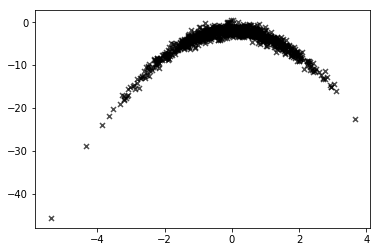

In [7]:
N = 1000
D = 2

### Create Banana Distribution
data = np.random.normal(size=(N, D))
z1 = 1.25*data[:,0]
z2 = data[:,1]/1.25 - 1.5*(z1**2 + 1.25)
data = np.hstack([z1[np.newaxis].T, z2[np.newaxis].T])
np.random.shuffle(data)

### Plot
plt.scatter(data[:,0], data[:,1], marker='x', s=25, c='k', alpha=.7)
plt.show()

######  Define Functions and Auto-Differentiate
Below we define the necessary functions (and their gradients) for a Gaussian variational approximation.  Define the model $p(\mathbf{X} | \boldsymbol{\theta})$ as a one-hidden-layer neural network with 50 units, and define the prior to be $p(\boldsymbol{\theta}) = \text{N}(\mu = 0, \sigma = .0001 )$...

In [4]:
# Gaussian prior and posterior
prior = {'mu': 0., 'sigma':.0001}

# Function for sampling from Gaussian location-scale form
def sample_from_Gauss(mu, log_sigma):
    e = np.random.normal()
    return mu + np.exp(log_sigma) * e, e

def logGaussPdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    return np.sum(np.log(1./np.sqrt(2*np.pi*params['sigma']**2)) + ((-.5/params['sigma']**2) * (x-params['mu'])**2))

# Regression NN with one hidden layer of 50 units
def logModel(W, b, x, y):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    y_hat = np.dot(h, W[:, 50:].T) + b[:, 50:]
    return np.sum( .5 * -(y - y_hat)**2 )

def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    return np.dot(h, W[:, 50:].T) + b[:, 50:]

# Gauss-to-Gauss KLD
def gaussKLD(mu, log_sigma, prior_mu=prior['mu'], prior_sigma=prior['sigma']):
    kl = -np.log(prior_sigma**2)
    kl += -(np.exp(2*log_sigma) + (mu - prior_mu)**2)/(prior_sigma**2)
    kl += 2*log_sigma + 1.
    return -0.5*kl.mean()


### GET DERIVATIVES ###

# d log p(X | \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

# d log p(\theta) / d \theta
dLogGauss_dX = grad(lambda x, mu, log_sigma: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))
dLogGauss_dMu = grad(lambda mu, x, log_sigma: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))
dLogGauss_dLogSig = grad(lambda log_sigma, x, mu: logGaussPdf(x, {'mu':mu, 'sigma': np.exp(log_sigma)}))

# d KLD / d phi
dKLD_dmu = grad(gaussKLD)
dKLD_dLogSigma = grad(lambda p1, p2: gaussKLD(p2, p1))

###  Variational Inference via ELBO

Now let's fit a Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--via the ELBO...

In [5]:
### INIT VARIATIONAL PARAMS 
phi = {'mu': .001 * np.random.normal(size=(1,100)), 'log_sigma': .0001*np.ones((1,100)), 'b': np.zeros((1,51))}


### ELBO OPTIMIZATION
maxEpochs = 200
learning_rate = .01
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 
               'log_sigma':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

n_samples = 50
for epochIdx in range(maxEpochs):
    
    elbo_val, elbo_grad_mu, elbo_grad_log_sigma, dModel_db = 0., 0., 0., 0.
    for s in range(n_samples):
        
        W_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dW = dLogModel_dW(W_hat, phi['b'], x, y) 
        elbo_grad_mu += 1./n_samples * dModel_dW * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dW * rand_seed * np.exp(phi['log_sigma'])
        
        dModel_db += 1./n_samples * dLogModel_db(phi['b'], W_hat, x, y)
        elbo_val += 1./n_samples * logModel(W_hat, phi['b'], x, y)
        
    elbo_grad_mu -= dKLD_dmu(phi['mu'], phi['log_sigma'])  
    elbo_grad_log_sigma -= dKLD_dLogSigma(phi['log_sigma'], phi['mu'])
    elbo_val -= gaussKLD(phi['mu'], phi['log_sigma'])
        
    phi['mu'] += get_AdaM_update(learning_rate, elbo_grad_mu , adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, elbo_grad_log_sigma, adam_values['log_sigma']) 
    phi['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b']) 

And get an MC estimate of the predictive uncertainty...